<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/06_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [23]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [24]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z / torch.exp(self.s)
        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [25]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

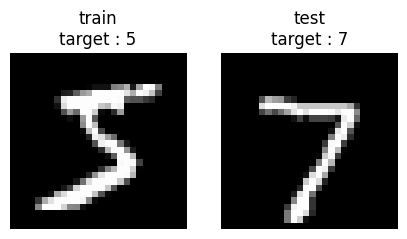

In [26]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [27]:
data_dim = 28*28

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=20000, shuffle=True)


In [28]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1123.09228515625
Epoch :  2   -----------> Loss :  1115.53955078125
Epoch :  3   -----------> Loss :  1097.4696451822917
Epoch :  4   -----------> Loss :  1085.3722330729167
Epoch :  5   -----------> Loss :  1073.0311279296875
Epoch :  6   -----------> Loss :  1061.4923095703125
Epoch :  7   -----------> Loss :  1049.73876953125
Epoch :  8   -----------> Loss :  1038.5175374348958
Epoch :  9   -----------> Loss :  1027.091776529948
Epoch :  10   -----------> Loss :  1015.3804728190104
Epoch :  11   -----------> Loss :  1003.5880330403646
Epoch :  12   -----------> Loss :  991.7735188802084
Epoch :  13   -----------> Loss :  980.0405883789062
Epoch :  14   -----------> Loss :  968.2620646158854
Epoch :  15   -----------> Loss :  956.5185953776041
Epoch :  16   -----------> Loss :  945.1855061848959
Epoch :  17   -----------> Loss :  933.3304036458334
Epoch :  18   -----------> Loss :  921.5980428059896
Epoch :  19   -----------> Loss :  909.910380045572

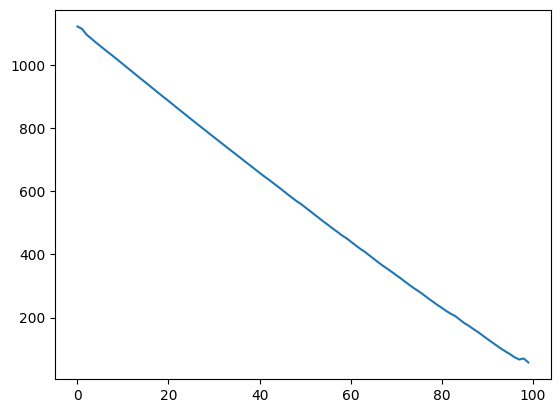

In [29]:
plt.plot(COST)

In [30]:
test = prior.sample((50,))
test

tensor([[-0.4875,  0.0359, -0.3082,  ...,  0.9715, -1.0580,  0.7587],
        [ 0.8460, -1.3957, -0.2096,  ..., -0.9624,  0.7414, -0.2955],
        [-0.7824, -0.5352,  0.5266,  ..., -1.7120,  1.1109,  0.2826],
        ...,
        [ 1.6060, -0.1317, -0.3658,  ..., -1.1198,  2.6504,  0.2645],
        [-0.8205, -0.7441,  1.2170,  ...,  0.9198,  0.3206, -0.7464],
        [ 1.2010,  2.2014,  0.8037,  ..., -0.9530,  0.2584,  1.0958]])

In [31]:
sonuc = model.f_inv(test)
sonuc

tensor([[-0.0938,  0.0493, -0.0520,  ...,  0.2601, -0.2034,  0.3147],
        [ 0.2401, -0.5310, -0.0365,  ..., -0.2272,  0.1753, -0.0635],
        [-0.1857, -0.1956,  0.5156,  ..., -0.4138,  0.2628,  0.1191],
        ...,
        [ 0.4341,  0.0238, -0.3846,  ..., -0.2772,  0.6417,  0.0984],
        [-0.1900, -0.3366,  0.7437,  ...,  0.2498,  0.0954, -0.2180],
        [ 0.3843,  0.7558,  0.2596,  ..., -0.2125,  0.1376,  0.4459]],
       grad_fn=<CopySlices>)

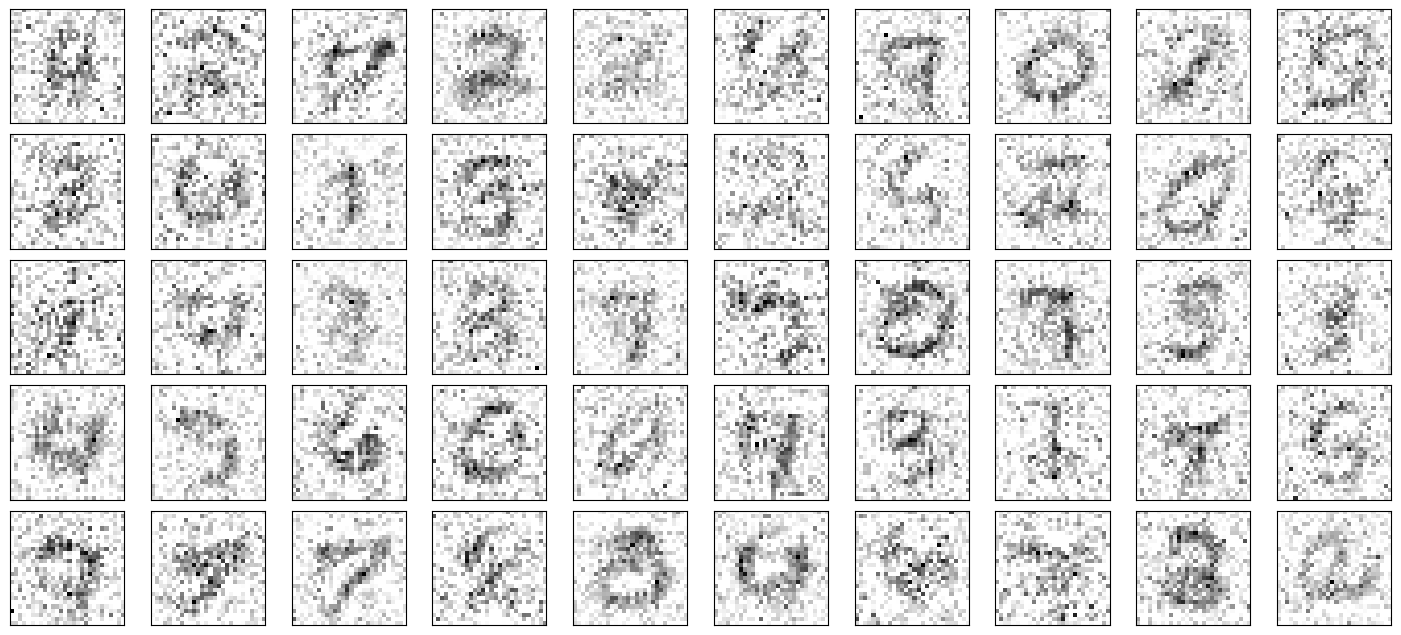

In [32]:
test = prior.sample((50,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary')

fig.show()